# Imports

In [3]:
# configure user-modules autoreload
%load_ext autoreload
%autoreload 2

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

# import utility functions
from train_utils import *

device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

# Data

In [4]:
import torchvision.transforms as T
from loader import get_dataloaders

# make dataloaders
TARGET_SIZE = 128
class Expand:
    def __init__(self, max_=2000):
        self.max = max_
    def __call__(self, input_tensor):
        for i in range(3):
            mx = 0
            shapes_new =  list(input_tensor.size())
            for i in range(3):
                if(mx < shapes_new[i]):
                    mx = shapes_new[i]
            self.max_size = [0]*3
            self.max_size[0] = 3
            self.max_size[1] = mx
            self.max_size[2] = mx
            if(self.max_size[i] > shapes_new[i]):
                shapes_new[i] = self.max_size[i] - input_tensor.shape[i]
                dop_torch = torch.ones(shapes_new)
                input_tensor = torch.cat((input_tensor, dop_torch), i)
        transform_end = T.Resize((TARGET_SIZE, TARGET_SIZE))
        return transform_end.forward(input_tensor)

transform = T.Compose([T.ToTensor(), Expand()])
train_loader, val_loader = get_dataloaders('../data', train_transform=transform, test_transform=transform, transform_name=f'Resize({TARGET_SIZE}, {TARGET_SIZE})')

# show dataset size
TRAIN_SIZE = len(train_loader.dataset)
VAL_SIZE = len(val_loader.dataset)
print(f'Train size: {TRAIN_SIZE}. Val size: {VAL_SIZE}. Val ratio: {VAL_SIZE / (TRAIN_SIZE + VAL_SIZE) * 100:.2f}%')

  0%|          | 0/2258 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'Resize'

# Model

In [3]:
from models.lenet import LeNet128, LeNet32

# Make sure that model performs correctly
with torch.no_grad():
    features, labels = next(iter(train_loader))
    print(f'Features size: {features.size()}. Labels size: {labels.size()}')
    logits = LeNet128()(features)

Features size: torch.Size([64, 3, 128, 128]). Labels size: torch.Size([64])


# Training

Train accuracy: 76.2%. Val accuracy: 68.4%
Train score: 4.25. Val score: 3.23
Train loss: 0.54. Val loss: 0.71


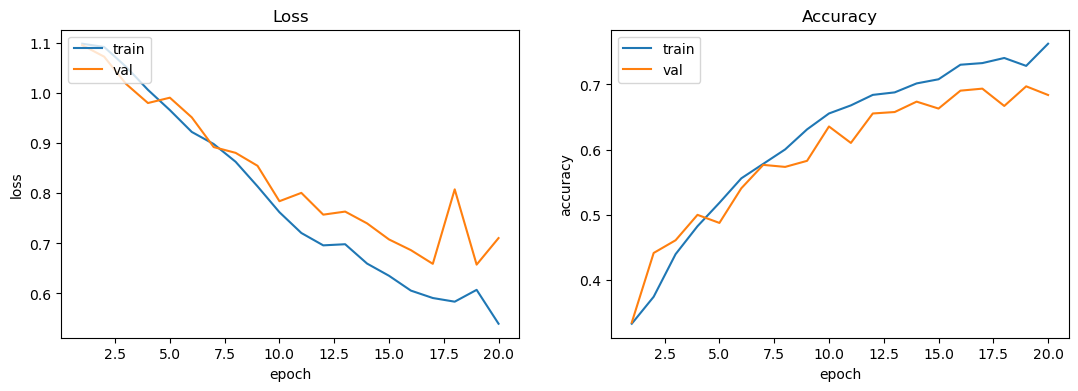

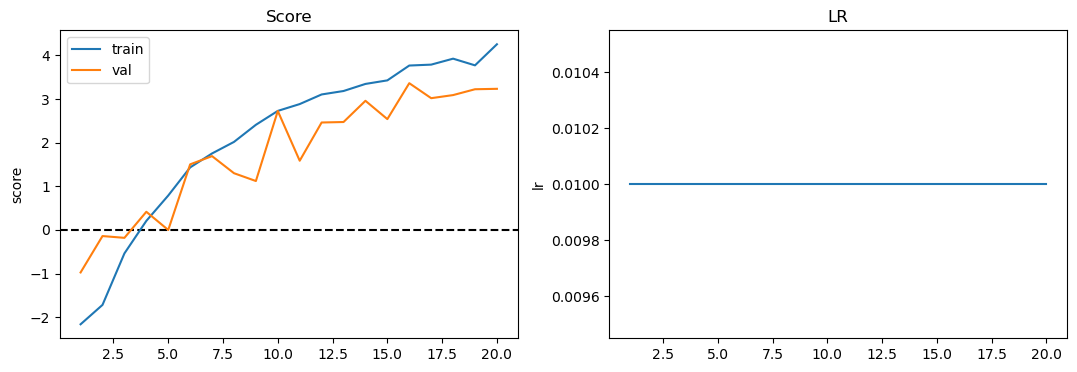

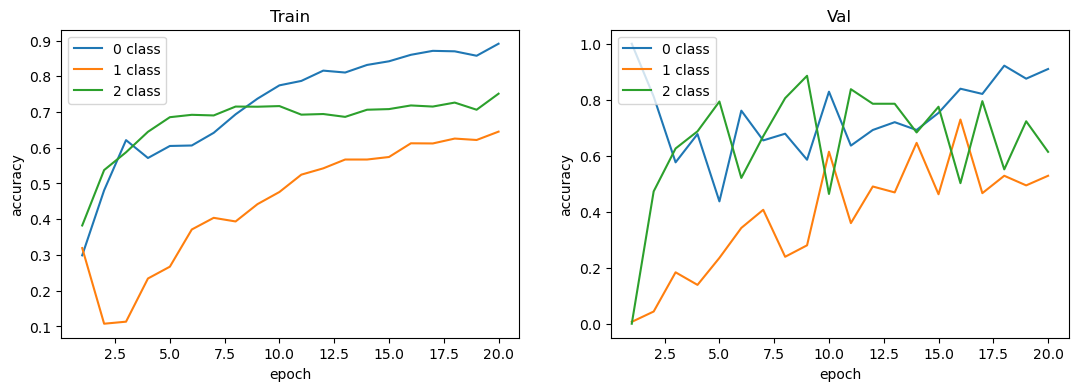

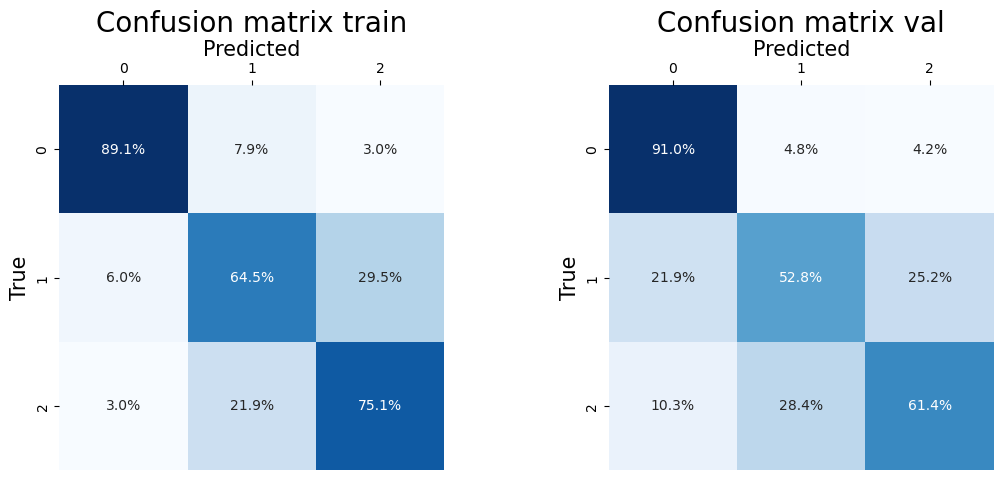

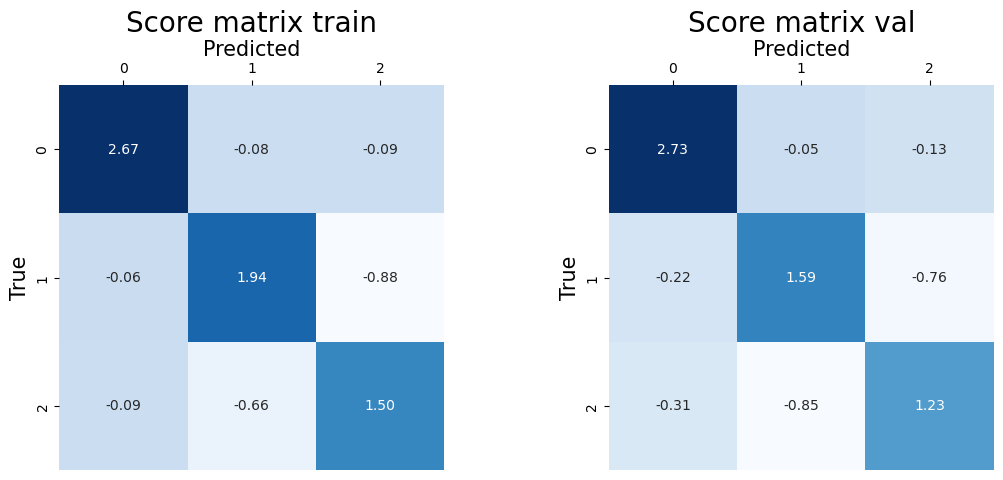

Success


In [4]:
# import one of the criterions
from criterions import CrossEntropyLoss, ScoreLoss
from train_utils import *

LOG_WANDB = False
N_EPOCHS = 20

FACTOR = 0.3
PATIENCE = 3

model = LeNet128().to(device)

LR = 1e-2
MOMENTUM = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = None  # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)
criterion = CrossEntropyLoss()

experiment_name = f'LeNet128'
notes = f'''
Optimizer: SGD({LR=}, {MOMENTUM=})
Scheduler: ReduceLROnPlateau({FACTOR=}, {PATIENCE=})
'''

if LOG_WANDB:
    wandb.login()
    wandb.init(
        project='VK Hackathon',
        name=experiment_name,
        notes=notes
    )

try:
    torch.manual_seed(0)
    train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, log_wandb=LOG_WANDB)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    if LOG_WANDB:
        wandb.finish()

print('Success')